In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, cohen_kappa_score, \
                            log_loss, brier_score_loss, hinge_loss, classification_report,roc_auc_score,confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV,RFE


In [4]:
# 读取数据
ADMET = pd.read_excel('./数据/ADMET.xlsx')
#ER = pd.read_excel('./数据/ERα_activity.xlsx')
Molecular = pd.read_excel('./数据/Molecular_Descriptor.xlsx') 

In [80]:
# 提取特征
fea_columns = Molecular.columns.drop('SMILES')
fea_columns

Index(['nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond',
       'nAtom', 'nHeavyAtom', 'nH',
       ...
       'MW', 'WTPT-1', 'WTPT-2', 'WTPT-3', 'WTPT-4', 'WTPT-5', 'WPATH', 'WPOL',
       'XLogP', 'Zagreb'],
      dtype='object', length=729)

In [6]:
# 删除0大于85%的特征
def dele0(data,columns):
    fea_columns0 = []
    for i in columns:
        if (sum(data[i]==0)/data.shape[0])<0.15:
            fea_columns0.append(i)
    return fea_columns0

In [7]:
# 删除0>85%的特征后剩余197个特征
fea_columns0 = dele0(Molecular,fea_columns)
sel_Molecular0 = Molecular[fea_columns0]

In [8]:
# 计算相关性
sel_Molecular_cor = sel_Molecular0.corr()

In [9]:
# 得到相关性>0.2的两列
cor_list = []
for i in range(len(sel_Molecular_cor.columns)):
    for j in range(i+1,len(sel_Molecular_cor.index)):
        if sel_Molecular_cor.iloc[i][j]>0.9 or sel_Molecular_cor.iloc[i][j]<-0.9:
            cor_list.append([sel_Molecular_cor.index[i],sel_Molecular_cor.index[j]])
print(len(cor_list))

818


In [10]:
# 根据相关性，选择删除的特征列
cor_del = []
for i in cor_list:
    cor_del.append(i[1])
fea_col1 = []
for i in fea_columns0:
    if i not in cor_del:
        fea_col1.append(i)
len(fea_col1)

80

In [11]:
# 80个特征的数据集
Molecular80 = Molecular[fea_col1]
# Molecular80.to_excel('C:/Users/TANGLINGHUI331/Desktop/Molecular80.xlsx')

Index(['Caco-2', 'CYP3A4', 'hERG', 'HOB', 'MN'], dtype='object')

In [13]:
# 统计ADMET分布情况
ADMET_col = ADMET.columns.drop('SMILES')
ADMET_count = pd.DataFrame(columns=ADMET_col,index=[0,1])
for i in range(1,6):
    #print(ADMET.iloc[:,i].value_counts())
    ADMET_count[ADMET_col[i-1]]=ADMET.iloc[:,i].value_counts()
    ADMET_count.to_excel('C:/Users/TANGLINGHUI331/Desktop/ADMET_count.xlsx')

In [81]:
ADMET_count

,Caco-2,CYP3A4,hERG,HOB,MN
0,1215,513,875,1465,460
1,759,1461,1099,509,1514


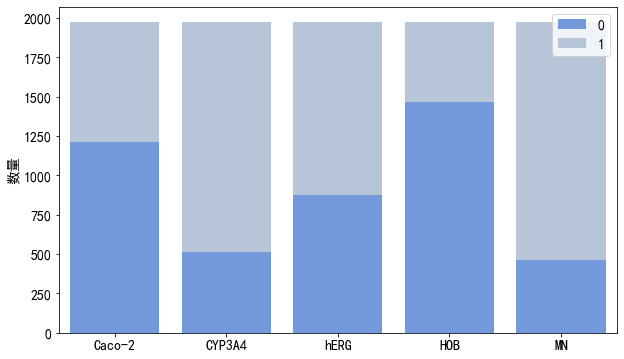

In [85]:
# ADMET分布绘图
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,6))
sns.barplot(x=ADMET_count.columns,y = ADMET_count.iloc[0],color='cornflowerblue',label=0)
sns.barplot(x=ADMET_count.columns,y = ADMET_count.iloc[1],bottom=ADMET_count.iloc[0],color = 'lightsteelblue',label=1)
plt.legend(loc=1)
plt.ylabel('数量')
plt.savefig('C:/Users/TANGLINGHUI331/Desktop/ADMET统计图.png')

plt.show()

In [58]:
# 统计ADMET组合的分布情况
ADMET_pair = pd.DataFrame(ADMET.iloc[:,1:].value_counts())
ADMET_pair = ADMET_pair.reset_index()
ADMET_pair['pair']=[0]*32
for i in range(ADMET_pair.shape[0]):
    ADMET_pair['pair'][i]='%d-%d-%d-%d-%d'%(ADMET_pair['Caco-2'][i],ADMET_pair['CYP3A4'][i],ADMET_pair['hERG'][i],ADMET_pair['HOB'][i],ADMET_pair['MN'][i],)

<ipython-input-58-36bcd1a4d0b5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADMET_pair['pair'][i]='%d-%d-%d-%d-%d'%(ADMET_pair['Caco-2'][i],ADMET_pair['CYP3A4'][i],ADMET_pair['hERG'][i],ADMET_pair['HOB'][i],ADMET_pair['MN'][i],)


In [59]:
ADMET_pair = ADMET_pair.iloc[:,5:]
ADMET_pair

,0,pair
0,571,0-1-1-0-1
1,145,0-1-1-0-0
2,129,1-0-0-0-1
3,119,0-1-1-1-1
4,117,0-0-0-0-1
5,112,0-1-0-0-1
6,87,1-1-0-0-1
7,80,1-0-0-1-1
8,73,1-1-0-1-1
9,69,1-1-0-0-0


In [104]:
ADMET_pair.to_excel('C:/Users/TANGLINGHUI331/Desktop/ADMET组合统计.xlsx')

In [105]:
# Caco-2 预测
X = Molecular80
y = ADMET['Caco-2']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [107]:
# 选择遗传算法输入的训练集
X_train1 = X_train[:1500]
print(X_train1.shape)
X_train2 = np.mat(X_train1)

(1500, 80)


In [108]:
# 设置遗传算法参数
pc = 0.02      # pc为变异的概率
t = 10       #遗传算法迭代的次数
n = 500        #种群的个体数,要求大于20以保证具有随机性

In [109]:
#遗传算法
def GA(d):
    population = np.zeros((n,80))      # 初始化种群
    for i in range(n):                # 定义种群的个体数为 n
        a = np.zeros(80-d)
        b = np.ones(d)                # 将选择的d维特征定义为个体c中的1
        c = np.append(a,b)
        c = (np.random.permutation(c.T)).T    # 随机生成一个d维的个体
        population[i] = c             # 初代的种群为 population，共有n个个体
        
    # 遗传算法的迭代次数为t
    fitness_change = np.zeros(t)
    for i in range(t):
        fitness = np.zeros(n)             # fitness为每一个个体的适应度值
        for j in range(n):
            fitness[j] = Jd(population[j])          # 计算每一个体的适应度值   
        population = selection(population,fitness)  # 通过概率选择产生新一代的种群
        population = crossover(population)          # 通过交叉产生新的个体
        population = mutation(population)           # 通过变异产生新个体
        fitness_change[i] = max(fitness)      #找出每一代的适应度最大的染色体的适应度值
        
        
    # 随着迭代的进行，每个个体的适应度值应该会不断增加，所以总的适应度值fitness求平均应该会变大
    
    best_fitness = max(fitness)
    best_people = population[fitness.argmax()]
    
    return best_people,best_fitness,fitness_change,population
    
    
    


#轮盘赌选择
def selection(population,fitness):
    fitness_sum = np.zeros(n)
    for i in range(n):
        if i==0:
            fitness_sum[i] = fitness[i]
        else:
            fitness_sum[i] = fitness[i] + fitness_sum[i-1]
    for i in range(n):
        fitness_sum[i] = fitness_sum[i] / sum(fitness)
    
    #选择新的种群
    population_new = np.zeros((n,80))
    for i in range(n):
        rand = np.random.uniform(0,1)
        for j in range(n):
            if j==0:
                if rand<=fitness_sum[j]:
                    population_new[i] = population[j]
            else:
                if fitness_sum[j-1]<rand and rand<=fitness_sum[j]:
                    population_new[i] = population[j]
    return population_new
                

#交叉操作
def crossover(population):
    father = population[0:250,:]
    mother = population[250:,:]
    np.random.shuffle(father)       # 将父代个体按行打乱以随机配对
    np.random.shuffle(mother)
    for i in range(250):
        father_1 = father[i]
        mother_1 = mother[i]
        one_zero = []
        zero_one = []
        for j in range(80):
            if father_1[j]==1 and mother_1[j]==0:
                one_zero.append(j)
            if father_1[j]==0 and mother_1[j]==1:
                zero_one.append(j)
        length1 = len(one_zero)
        length2 = len(zero_one)
        length = max(length1,length2)
        half_length = int(length/2)        #half_length为交叉的位数 
        for k in range(half_length):       #进行交叉操作
            p = one_zero[k]
            q = zero_one[k]
            father_1[p]=0
            mother_1[p]=1
            father_1[q]=1
            mother_1[q]=0
        father[i] = father_1               #将交叉后的个体替换原来的个体
        mother[i] = mother_1
    population = np.append(father,mother,axis=0)
    return population
                
            
    
#变异操作
def mutation(population):
    for i in range(n):
        c = np.random.uniform(0,1)
        if c<=pc:
            mutation_s = population[i]
            zero = []                           # zero存的是变异个体中第几个数为0
            one = []                            # one存的是变异个体中第几个数为1
            for j in range(80):
                if mutation_s[j]==0:
                    zero.append(j)
                else:
                    one.append(j)
            a = np.random.randint(0,len(zero))    # e是随机选择由0变为1的位置
            b = np.random.randint(0,len(one))     # f是随机选择由1变为0的位置
            e = zero[a]
            f = one[b]
            mutation_s[e] = 1
            mutation_s[f] = 0
            population[i] = mutation_s
            
    return population


#个体适应度函数 Jd(x)，x是d维特征向量(1*80维的行向量,1表示选择该特征)
def Jd(x):
    #从特征向量x中提取出相应的特征
    Feature = np.zeros(d)        #数组Feature用来存 x选择的是哪d个特征
    k = 0
    for i in range(80):
        if x[i] == 1:
            Feature[k] = i
            k+=1
    
    #将4个特征从X_train2数据集中取出重组成一个1500*d的矩阵X_train3
    X_train3 = np.zeros((1500,1))
    for i in range(d):
        p = Feature[i]
        p = p.astype(int)
        q = X_train2[:,p]
        q = q.reshape(1500,1)
        X_train3 = np.append(X_train3,q,axis=1)
    X_train3 = np.delete(X_train3,0,axis=1)
    
    #求类间离散度矩阵Sb
    X_train3_1 = X_train3[0:500,:]        #数据集分为三类
    X_train3_2 = X_train3[500:1000,:]
    X_train3_3 = X_train3[1000:1500,:]
    m = np.mean(X_train3,axis=0)       #总体均值向量
    m1 = np.mean(X_train3_1,axis=0)    #第一类的均值向量
    m2 = np.mean(X_train3_2,axis=0)    #第二类的均值向量
    m3 = np.mean(X_train3_3,axis=0)    #第二类的均值向量
    m = m.reshape(d,1)               #将均值向量转换为列向量以便于计算
    m1 = m1.reshape(d,1)
    m2 = m2.reshape(d,1)
    m3 = m3.reshape(d,1)
    Sb = ((m1 - m).dot((m1 - m).T) + (m2 - m).dot((m2 - m).T) + (m3 - m).dot((m3 - m).T))/3 #除以类别个数
    
    #求类内离散度矩阵Sw
    S1 = np.zeros((d,d))
    S2 = np.zeros((d,d))
    S3 = np.zeros((d,d))
    for i in range(500):
        S1 += (X_train3_1[i].reshape(d,1)-m1).dot((X_train3_1[i].reshape(d,1)-m1).T)
    S1 = S1/500
    for i in range(500):
        S2 += (X_train3_2[i].reshape(d,1)-m2).dot((X_train3_2[i].reshape(d,1)-m2).T)
    S2 = S2/500
    for i in range(500):
        S3 += (X_train3_3[i].reshape(d,1)-m3).dot((X_train3_3[i].reshape(d,1)-m3).T)
    S3 = S3/500
    
    Sw = (S1 + S2 + S3)/3
    
    #计算个体适应度函数 Jd(x)
    J1 = np.trace(Sb)
    J2 = np.trace(Sw)
    Jd = J1/J2
    
    return Jd
    


if __name__ == '__main__':
    
    # best_d = np.zeros(d)          # judge存的是每一个维数的最优适应度
    
    # fitness_change是遗传算法在迭代过程中适应度变化
    # best是每一维数迭代到最后的最优的适应度，用于比较
    
    for d in range(30,31):
        print("\n")
        best_people,best_fitness,fitness_change,best_population = GA(d)
        choice = np.zeros(d)
        k = 0
        print("在取%d维的时候，通过遗传算法得出的最优适应度值为：%.6f"%(d,best_fitness))
        print("选出的最优染色体为：")
        print(best_people)
        for j in range(80):
            if best_people[j] == 1:
                choice[k]=j+1
                k+=1
        print("选出的最优特征为：")
        print(choice)
    
    '''
    #画图
    x = np.arange(0,t,1)
    plt.xlabel('dimension')
    plt.ylabel('fitness')
    plt.ylim((0,50))            # y坐标的范围
    plt.plot(x,fitness_change,'b')
    '''
    
    



在取30维的时候，通过遗传算法得出的最优适应度值为：0.001868
选出的最优染色体为：
[0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 0. 1. 1.]
选出的最优特征为：
[ 2.  4.  5.  6.  7.  8.  9. 10. 19. 23. 24. 36. 37. 38. 41. 47. 48. 49.
 50. 53. 57. 61. 62. 63. 66. 67. 71. 72. 79. 80.]


In [110]:
# 得到遗传算法选择的30个特征
choice = choice.astype(int)
ga_fea = X_train.columns[choice-1]
ga_fea

Index(['ALogp2', 'naAromAtom', 'nO', 'ATSc1', 'ATSc3', 'ATSc4', 'ATSc5',
       'ATSm1', 'C3SP2', 'SC-3', 'SC-5', 'minwHBa', 'minHaaCH', 'minaaCH',
       'maxHBa', 'hmin', 'gmin', 'LipoaffinityIndex', 'ETA_AlphaP',
       'ETA_Epsilon_3', 'ETA_Shape_Y', 'ETA_BetaP_ns_d', 'ETA_EtaP_F',
       'ETA_Eta_B', 'FMF', 'nHBAcc', 'MDEC-33', 'MLFER_A', 'nTRing', 'XLogP'],
      dtype='object')

In [113]:
# RFE筛选特征
def RFE_sel(x_train,ytrain):

    # 分类
    rf = RandomForestClassifier(oob_score=True)
    rfe = RFE(estimator=rf,n_features_to_select=30)
    rfe.fit(x_train,ytrain)

#    print("是否应该选择 %s" % rfe.support_)
    
    ref_fea = x_train.columns[rfe.support_]
    
    return ref_fea

one = RFE_sel(X_train,y_train)

Index(['AMR', 'naAromAtom', 'ATSc1', 'ATSm1', 'BCUTc-1l', 'BCUTc-1h',
       'BCUTp-1h', 'nBondsD', 'SCH-6', 'SCH-7', 'VCH-6', 'CrippenLogP', 'SHBa',
       'minHBa', 'minwHBa', 'maxHBd', 'maxHBa', 'hmin', 'LipoaffinityIndex',
       'ETA_dEpsilon_D', 'ETA_Shape_P', 'ETA_Shape_Y', 'ETA_BetaP',
       'ETA_BetaP_s', 'FMF', 'MDEC-23', 'MLFER_BH', 'MLFER_S', 'MLFER_E',
       'PetitjeanNumber'],
      dtype='object')

In [146]:
# 将遗传算法与RFE选择的特征结合
def sel_fea(Xtrain,rfe_feature,a):
    sel_fea = []
    for i in ga_fea:
        sel_fea.append(i)
    for j in rfe_feature:
        if j not in sel_fea:
            sel_fea.append(j)
    d = len(sel_fea)

    # 得到51个特征的训练集
    sel_X = Xtrain[sel_fea]

    sel_X.to_csv('C:/Users/TANGLINGHUI331/Desktop/第%d次筛选后%d个特征数据.csv'%(a,d))
    
    return sel_fea,sel_X

In [153]:
# 计算重要性
def importance(ytrain,selX,a):
    # 随机森林得到特征重要性
    rf1 = RandomForestClassifier(random_state=0,oob_score=True)
    rf1.fit(selX,ytrain)
    importance1 = rf1.feature_importances_
    indices1 = np.argsort(importance)[::-1]
    features1 = selX.columns
    
    # XGBoost得到特征重要性
    xgr = xgb.XGBClassifier()
    xgr.fit(selX,ytrain)
    fscore2 = xgr.feature_importances_
    indices2 = np.argsort(fscore)[::-1]
    features2 = selX.columns
    
    # 得到得分和排名
    score = pd.DataFrame(columns = ['features','xg_score','rf_score'])
    score['features'] = features1
    score['xg_score'] = fscore2
    score['rf_score'] = importance1
    sort_score1 = score.sort_values(by='xg_score')
    sort_score2 = score.sort_values(by='rf_score')
    score['xg_rank'] = score['xg_score'].rank(ascending=False)
    score['rf_rank'] = score['rf_score'].rank(ascending=False)
    score['score'] = (score['xg_score']+score['rf_score'])/2
    score['rank'] = score['score'].rank(ascending=False)
    final_score = score.sort_values(by='rank')
    final_score.to_excel('C:/Users/TANGLINGHUI331/Desktop/第%d个特征排序.xlsx'%a)
    return final_score

In [148]:
# CYP3A4 预测
if __name__ == '__main__':
    X2 = Molecular80
    y2 = ADMET['CYP3A4']
    X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,y2,test_size=0.2)
    rfe_fea2 = RFE_sel(X_train2,y_train2)
    sel_fea2,sel_X2 = sel_fea(X_train2,rfe_fea2,2)
    final_score2 = importance(y_train2,sel_X2,2)

In [157]:
# hERG 预测
if __name__ == '__main__':
    X3 = Molecular80
    y3 = ADMET['hERG']
    X_train3,X_test3,y_train3,y_test3 = train_test_split(X3,y3,test_size=0.2)
    rfe_fea3 = RFE_sel(X_train3,y_train3)
    sel_fea3,sel_X3 = sel_fea(X_train3,rfe_fea3,3)
    final_score3 = importance(y_train3,sel_X3,3)

In [160]:
# HOB 预测
if __name__ == '__main__':
    X4 = Molecular80
    y4 = ADMET['HOB']
    X_train4,X_test4,y_train4,y_test4 = train_test_split(X4,y4,test_size=0.2)
    rfe_fea4 = RFE_sel(X_train4,y_train4)
    sel_fea4,sel_X4 = sel_fea(X_train4,rfe_fea4,4)
    final_score4 = importance(y_train4,sel_X4,4)

D:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:08:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [161]:
# MN预测
if __name__ == '__main__':
    X5 = Molecular80
    y5 = ADMET['MN']
    X_train5,X_test5,y_train5,y_test5 = train_test_split(X5,y5,test_size=0.2)
    rfe_fea5 = RFE_sel(X_train5,y_train5)
    sel_fea5,sel_X5 = sel_fea(X_train5,rfe_fea5,5)
    final_score5 = importance(y_train5,sel_X5,5)

D:\anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:09:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [99]:
# 第三问得分排名
fin_score1 = pd.read_excel('C:/Users/TANGLINGHUI331/Desktop/华为杯/建模/Caco-2-51个特征排序.xlsx')
fin_score2 = pd.read_excel('C:/Users/TANGLINGHUI331/Desktop/华为杯/建模/CYP3A4特征排序.xlsx')
fin_score3 = pd.read_excel('C:/Users/TANGLINGHUI331/Desktop/华为杯/建模/hERG特征排序.xlsx')
fin_score4 = pd.read_excel('C:/Users/TANGLINGHUI331/Desktop/华为杯/建模/HOB特征排序.xlsx')
fin_score5 = pd.read_excel('C:/Users/TANGLINGHUI331/Desktop/华为杯/建模/MN特征排序.xlsx')
fin_score1 = fin_score1.iloc[:20,1:]
fin_score2 = fin_score2.iloc[:20,1:]
fin_score3 = fin_score3.iloc[:20,1:]
fin_score4 = fin_score4.iloc[:20,1:]
fin_score5 = fin_score5.iloc[:20,1:]

In [109]:
feature_list = []
feature_list.append(list(fin_score1['features'].values))
feature_list.append(list(fin_score2['features'].values))
feature_list.append(list(fin_score3['features'].values))
feature_list.append(list(fin_score4['features'].values))
feature_list.append(list(fin_score5['features'].values))
feature_list

[['AMR',
  'naAromAtom',
  'nBondsD',
  'ETA_BetaP_s',
  'ATSm1',
  'MLFER_S',
  'nO',
  'MLFER_BH',
  'SCH-6',
  'MLFER_E',
  'hmin',
  'ATSc1',
  'MDEC-23',
  'VCH-6',
  'minwHBa',
  'SCH-7',
  'PetitjeanNumber',
  'BCUTc-1h',
  'XLogP',
  'ETA_BetaP_ns_d'],
 ['SC-3',
  'ATSc5',
  'ATSc4',
  'SPC-4',
  'ALogp2',
  'LipoaffinityIndex',
  'nTRing',
  'nO',
  'hmin',
  'XLogP',
  'MDEC-23',
  'VCH-6',
  'ETA_dEpsilon_B',
  'ETA_dEpsilon_D',
  'ETA_BetaP',
  'BCUTp-1h',
  'ATSc3',
  'minHBa',
  'MDEC-33',
  'gmin'],
 ['nTRing',
  'maxHBa',
  'ATSc5',
  'nHBAcc',
  'ALogp2',
  'minHBd',
  'ETA_BetaP',
  'minwHBa',
  'MDEC-33',
  'FMF',
  'ATSc1',
  'MDEC-23',
  'maxaasC',
  'AMR',
  'minHBa',
  'nO',
  'maxaaCH',
  'XLogP',
  'LipoaffinityIndex',
  'ATSc4'],
 ['gmin',
  'ATSc3',
  'minwHBa',
  'BCUTp-1l',
  'ETA_BetaP',
  'ATSc5',
  'ALogp2',
  'minHBa',
  'ETA_dEpsilon_B',
  'MLFER_A',
  'SC-3',
  'minaasC',
  'ETA_AlphaP',
  'BCUTc-1h',
  'ETA_EtaP_F',
  'ATSc1',
  'ETA_BetaP_s',
  'AMR

In [119]:
fea_all = pd.DataFrame(columns=[ADMET.columns.drop('SMILES')])
fea_all['Caco-2']=feature_list[0]
fea_all['CYP3A4']=feature_list[1]
fea_all['hERG']=feature_list[2]
fea_all['HOB']=feature_list[3]
fea_all['MN']=feature_list[4]
fea_all.head()

,Caco-2,CYP3A4,hERG,HOB,MN
0,AMR,SC-3,nTRing,gmin,nTRing
1,naAromAtom,ATSc5,maxHBa,ATSc3,minHBa
2,nBondsD,ATSc4,ATSc5,minwHBa,MDEC-23
3,ETA_BetaP_s,SPC-4,nHBAcc,BCUTp-1l,VCH-6
4,ATSm1,ALogp2,ALogp2,ETA_BetaP,ATSc3


In [131]:
fea_all.to_excel('C:/Users/TANGLINGHUI331/Desktop/ADMET筛选所有特征.xlsx')

In [162]:
fea_list = list(fin_score1['features'].values)+list(fin_score2['features'].values)+list(fin_score3['features'].values)+list(fin_score4['features'].values)+list(fin_score5['features'].values)
fea_count = pd.DataFrame(fea_list).value_counts()
fea_count

ALogp2               4
ATSc5                4
MDEC-23              4
minHBa               4
ETA_BetaP            3
gmin                 3
hmin                 3
AMR                  3
MDEC-33              3
LipoaffinityIndex    3
VCH-6                3
minwHBa              3
XLogP                3
ATSc4                3
ATSc1                3
ATSc3                3
nO                   3
nTRing               3
BCUTc-1h             3
ATSm1                2
SC-3                 2
ETA_dEpsilon_B       2
ETA_BetaP_s          2
maxHBa               2
hmax                 1
nBondsD              1
maxaaCH              1
maxaasC              1
minHBd               1
minHaaCH             1
nHBAcc               1
minaasC              1
minaaCH              1
MLFER_E              1
SPC-4                1
ETA_EtaP_F           1
BCUTc-1l             1
BCUTp-1h             1
BCUTp-1l             1
ETA_AlphaP           1
ETA_BetaP_ns_d       1
ETA_Epsilon_2        1
ETA_EtaP_B_RC        1
ETA_dEpsilo

In [164]:
fea_count.to_excel('C:/Users/TANGLINGHUI331/Desktop/ADMET筛选所有特征统计.xlsx')

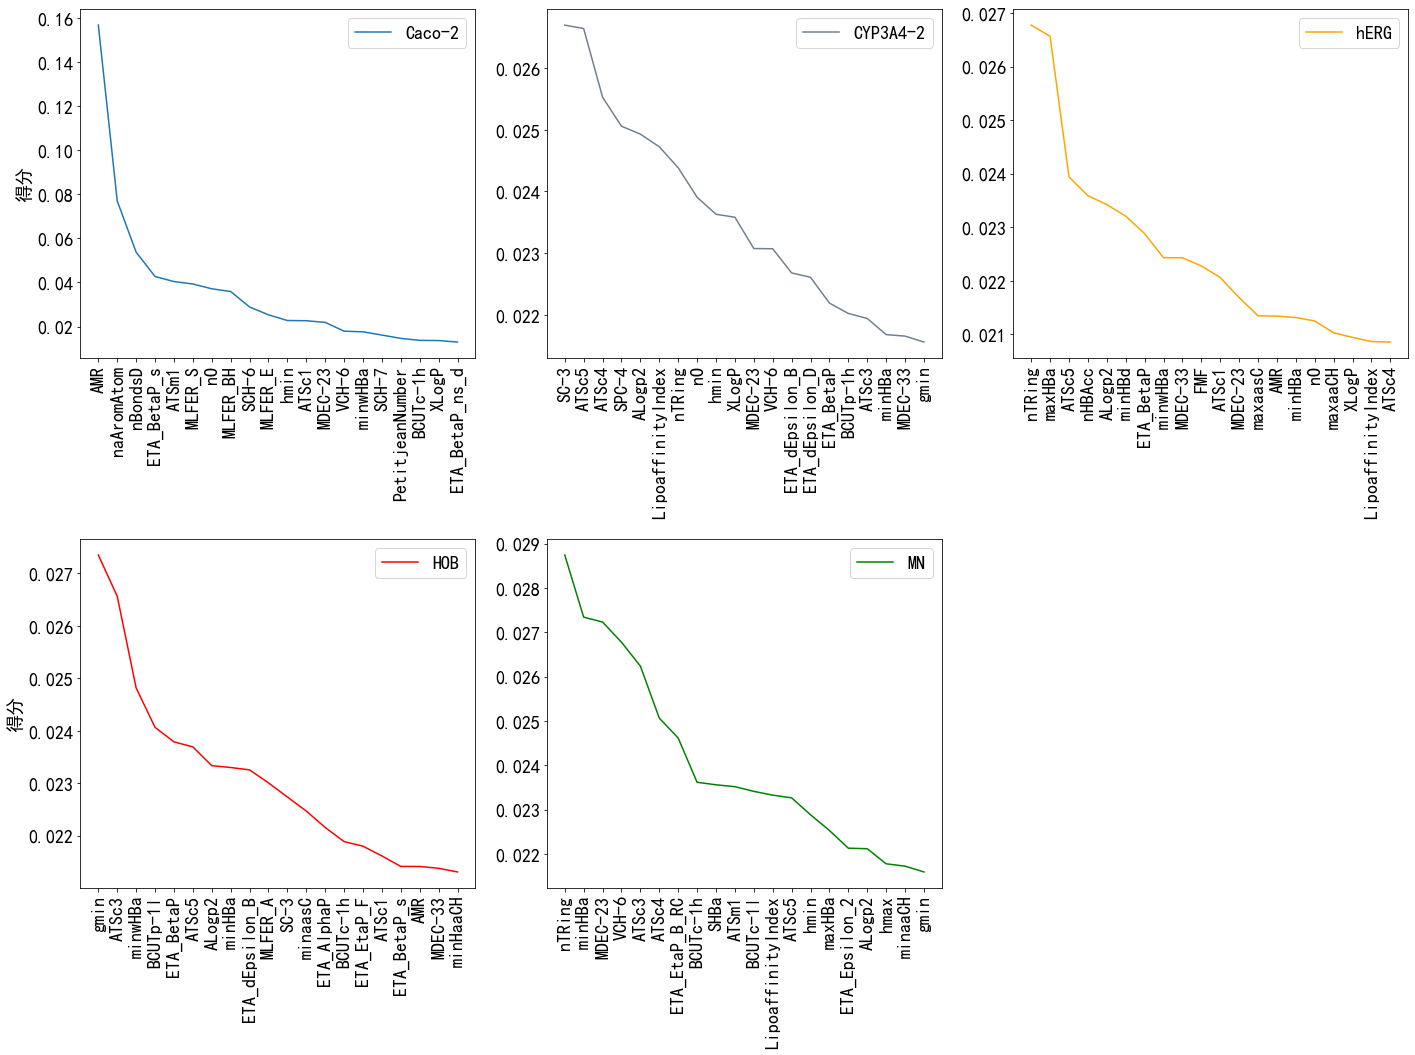

In [196]:
plt.figure(figsize=(20,15))
# plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams.update({'font.size': 18})
plt.subplot(231)

sns.lineplot(x=fin_score1['features'],y=fin_score1['score'],label='Caco-2')
plt.xticks(rotation=90)
plt.ylabel('得分')
plt.xlabel('')
plt.legend(loc=0)

plt.subplot(232)
sns.lineplot(x=fin_score2['features'],y=fin_score2['score'],label='CYP3A4-2',color='slategrey')
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.legend(loc=0)

plt.subplot(233)
sns.lineplot(x=fin_score3['features'],y=fin_score3['score'],label='hERG',color='orange')
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.legend(loc=0)

plt.subplot(234)

sns.lineplot(x=fin_score4['features'],y=fin_score4['score'],label='HOB',color='red')
plt.xticks(rotation=90)
plt.ylabel('得分')
plt.xlabel('')
plt.legend(loc=0)

plt.subplot(235)

sns.lineplot(x=fin_score5['features'],y=fin_score5['score'],label='MN',color='green')
plt.xticks(rotation=90)
plt.ylabel('')
plt.xlabel('')
plt.legend(loc=0)
plt.tight_layout()

plt.savefig('C:/Users/TANGLINGHUI331/Desktop/ADMET得分图.png')
plt.show()